In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.7.0


## Hyperparameters

In [29]:
seq_len = 128

**Load price and volume data**

In [30]:
df = pd.read_csv('Bitcoin Historical Data - Investing.com.csv', delimiter=',', usecols=['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True,inplace=True)
# df.drop(['Change'], axis=1,inplace=True)
df.head()

,Date,Close,Open,High,Low,Volume
0,2011-06-26,16.5,17.5,17.5,14,15.05K
1,2011-06-27,16.8,16.5,18,15,31.45K
2,2011-06-28,17,16.8,17.5,16.5,24.40K
3,2011-06-29,16.9,17,17.2,16.7,21.04K
4,2011-06-30,16.1,16.9,17,15.7,34.96K


In [31]:
df['Close'] = df['Close'].apply(lambda x: x.replace(',','')).astype(float)
df['Open'] = df['Open'].apply(lambda x: x.replace(',','')).astype(float)
df['High'] = df['High'].apply(lambda x: x.replace(',','')).astype(float)
df['Low'] = df['Low'].apply(lambda x: x.replace(',','')).astype(float)
df['Volume'] = df['Volume'].apply(lambda x: x.replace('K','e+03')).apply(lambda x: x.replace('M','e+06')).astype(float)

In [32]:
df.head()

,Date,Close,Open,High,Low,Volume
0,2011-06-26,16.5,17.5,17.5,14.0,15050.0
1,2011-06-27,16.8,16.5,18.0,15.0,31450.0
2,2011-06-28,17.0,16.8,17.5,16.5,24400.0
3,2011-06-29,16.9,17.0,17.2,16.7,21040.0
4,2011-06-30,16.1,16.9,17.0,15.7,34960.0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3843 entries, 0 to 3842
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3843 non-null   datetime64[ns]
 1   Close   3843 non-null   float64       
 2   Open    3843 non-null   float64       
 3   High    3843 non-null   float64       
 4   Low     3843 non-null   float64       
 5   Volume  3843 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 180.3 KB


## Plot daily closing prices

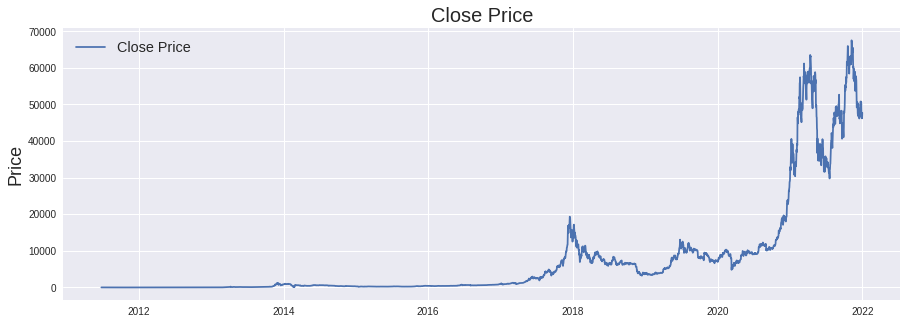

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(df['Date'],df['Close'])
plt.ylabel('Price', fontsize=18)
plt.title("Close Price", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

## Plot daily volumes

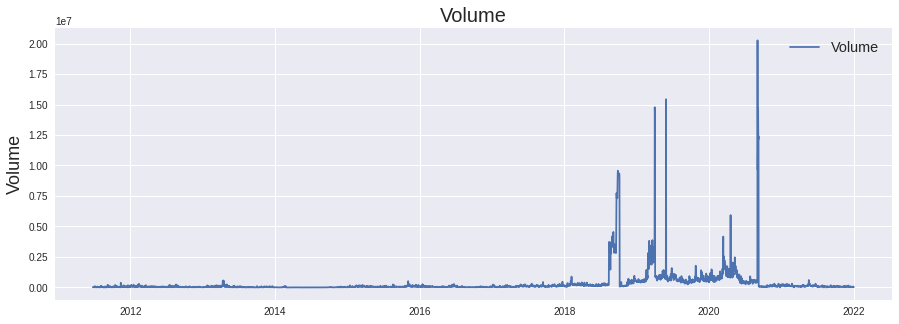

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(df['Date'],df['Volume'])
plt.ylabel('Volume', fontsize=18)
plt.title("Volume", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Calculate normalized percentage change for all columns

In [36]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (3074, 5)
Validation data shape: (384, 5)
Test data shape: (384, 5)


,Close,Open,High,Low,Volume
1,0.126680,0.110605,0.128897,0.138043,0.006847
2,0.125341,0.126680,0.116872,0.144141,0.002535
3,0.121545,0.125341,0.119142,0.125387,0.002819
4,0.112698,0.121545,0.120319,0.110021,0.005442
5,0.113522,0.112698,0.119034,0.117363,0.003113


## Plot daily changes of close prices and volume

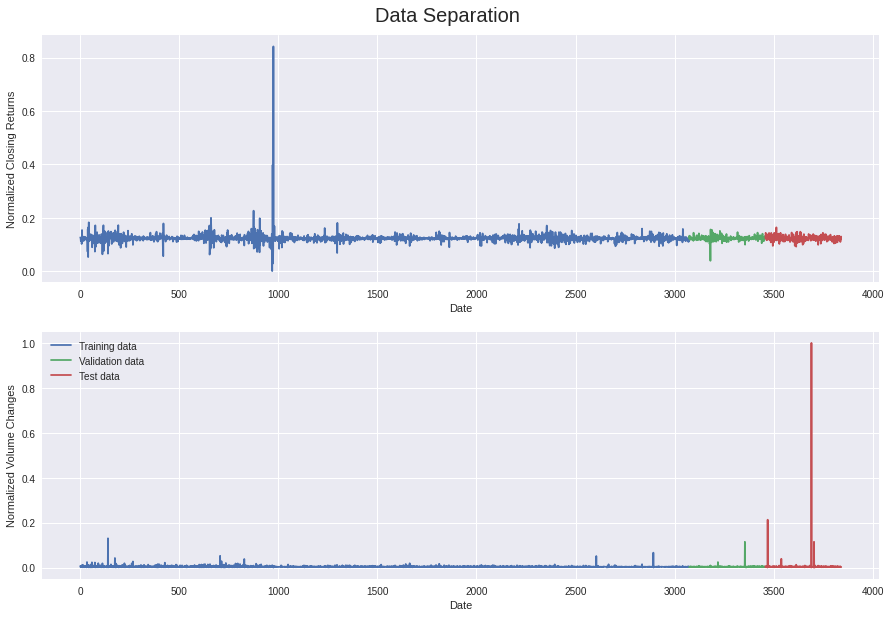

In [37]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Create chunks of training, validation and test data

In [38]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2946, 128, 5) (2946,)
(256, 128, 5) (256,)


# **Moving Average Analysis**

## Loading data again to apply a moving average effect

In [39]:
df = pd.read_csv('/content/Bitcoin Historical Data - Investing.com.csv', delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True,inplace=True)

df['Close'] = df['Close'].apply(lambda x: x.replace(',','')).astype(float)
df['Open'] = df['Open'].apply(lambda x: x.replace(',','')).astype(float)
df['High'] = df['High'].apply(lambda x: x.replace(',','')).astype(float)
df['Low'] = df['Low'].apply(lambda x: x.replace(',','')).astype(float)
df['Volume'] = df['Volume'].apply(lambda x: x.replace('K','e+03')).apply(lambda x: x.replace('M','e+06')).astype(float)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

df.head()

,Date,Close,Open,High,Low,Volume
9,2011-07-05,15.63,16.09,16.59,14.79,33278.0
10,2011-07-06,15.46,15.63,16.49,14.66,42955.0
11,2011-07-07,15.26,15.46,16.28,14.61,45257.0
12,2011-07-08,14.99,15.26,16.09,14.35,46302.0
13,2011-07-09,14.74,14.99,15.84,14.08,45389.0


## Moving Average - Plot daily closing prices

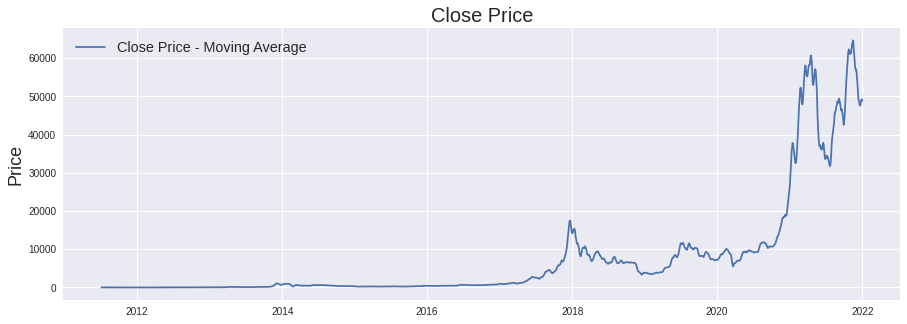

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(df['Date'],df['Close'])
plt.ylabel('Price', fontsize=18)
plt.title("Close Price", fontsize=20)
plt.legend(['Close Price - Moving Average'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Plot daily volumes

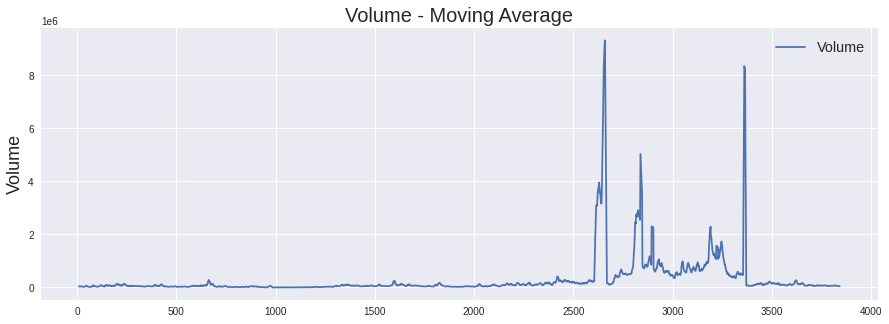

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.ylabel('Volume', fontsize=18)
plt.title("Volume - Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [42]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (3067, 5)
Validation data shape: (383, 5)
Test data shape: (383, 5)


,Close,Open,High,Low,Volume
10,0.430073,0.375367,0.445049,0.436518,0.242541
11,0.423710,0.430073,0.424333,0.453132,0.195732
12,0.409019,0.423710,0.427620,0.408702,0.189713
13,0.412156,0.409019,0.415677,0.405554,0.181266
14,0.438521,0.412156,0.438318,0.435149,0.189644


## Moving Average - Plot daily changes of close prices and volume

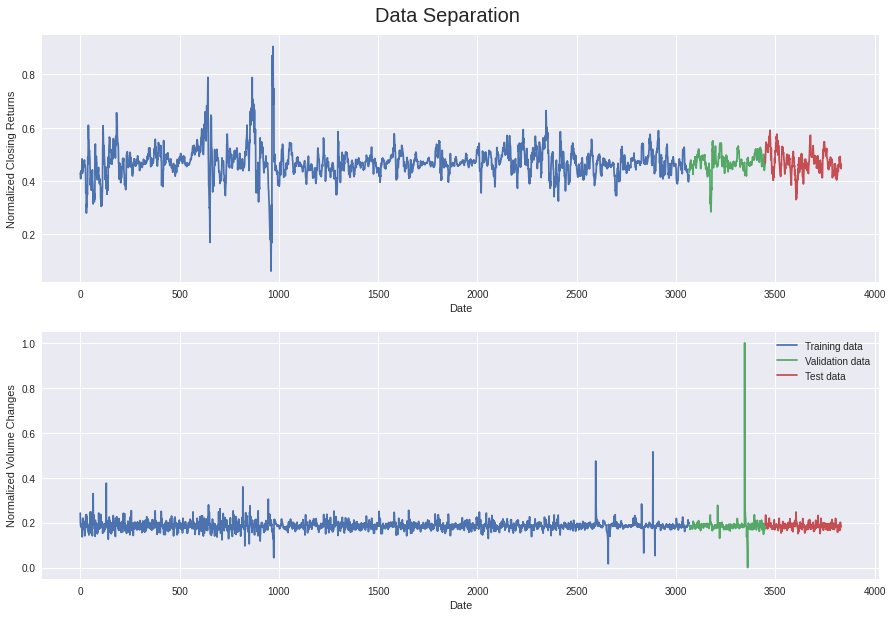

In [43]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Moving Average - Create chunks of training, validation and test data

In [44]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2939, 128, 5) (2939,)
(255, 128, 5) (255,)


# **Moving Average - Testing different model architectures**

### Moving Average - Bi-LSTM model

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00057, saving model to Bi-LSTM.hdf5
2/2 - 10s - loss: 0.0051 - mae: 0.0538 - mape: 145814.4219 - val_loss: 5.7379e-04 - val_mae: 0.0186 - val_mape: 3.8745 - 10s/epoch - 5s/step
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.00057
2/2 - 1s - loss: 0.0036 - mae: 0.0388 - mape: 171788.4219 - val_loss: 5.7638e-04 - val_mae: 0.0195 - val_mape: 4.1066 - 827ms/epoch - 413ms/step
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.00057
2/2 - 1s - loss: 0.0035 - mae: 0.0377 - mape: 155460.9844 - val_loss: 8.7798e-04 - val_mae: 0.0223 - val_mape: 4.5278 - 796ms/epoch - 398ms/step
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.00057
2/2 - 1s - loss: 0.0035 - mae: 0.0371 - mape: 156287.1875 - val_loss: 6.0568e-04 - val_mae: 0.0204 - val_mape: 4.3213 - 799ms/epoch - 399ms/step
Epoch 5/200

Epoch 00005: val_loss did not improve from 0.00057
2/2 - 1s - loss: 0.0034 - mae: 0.0375 - mape: 163788.3750 - val_loss: 5.83

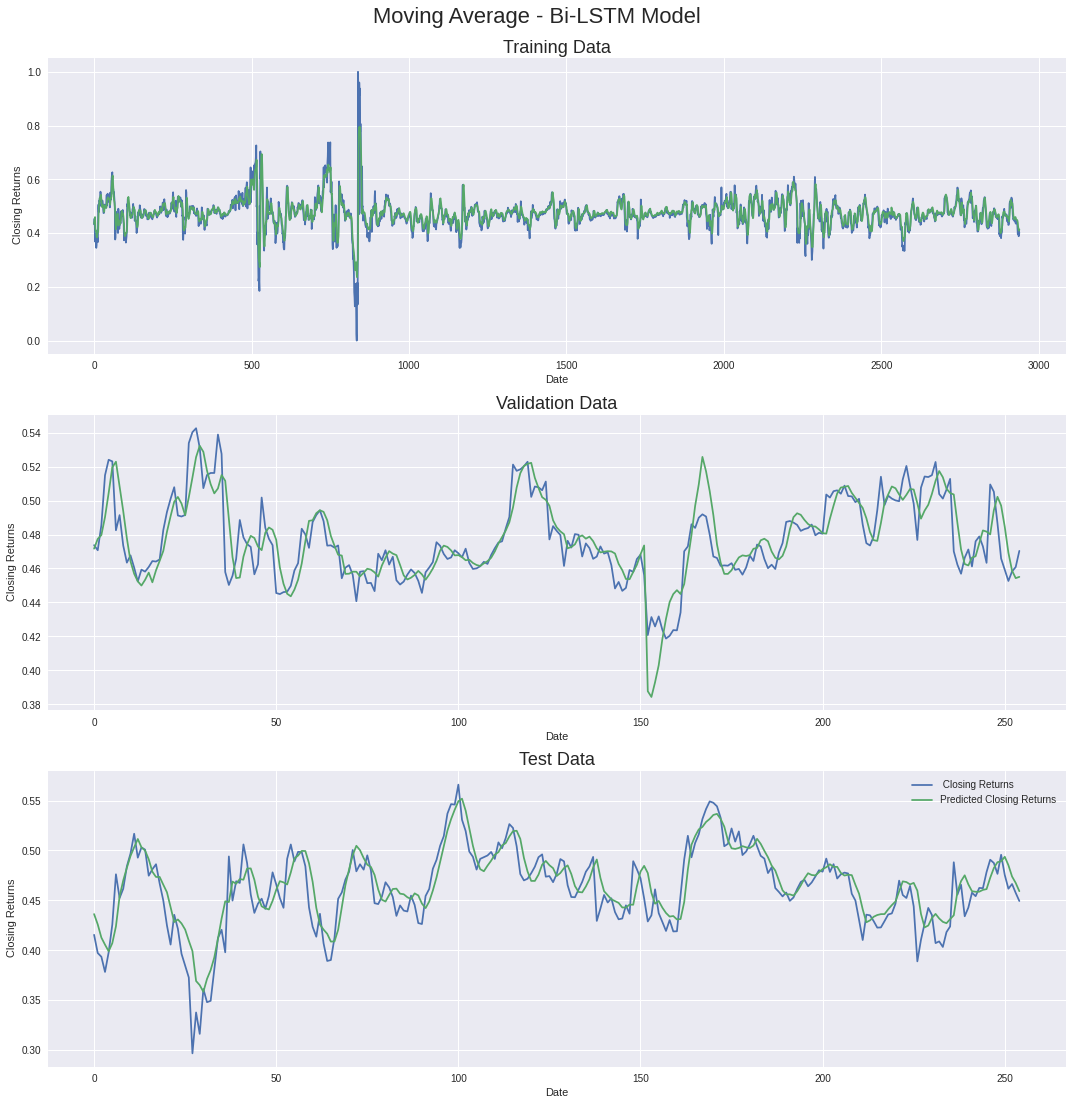

In [45]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/content/Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[128:, 3], label=' Closing Returns')
ax11.plot(train_pred, label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel(' Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[128:, 3], label=' Closing Returns')
ax21.plot(val_pred, label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel(' Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[128:, 3], label=' Closing Returns')
ax31.plot(test_pred, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel(' Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

## **Conculsion**
As expected applying a moving average to the price data smoothed the return distribution and thus lead to an improved model performance. 

However, when applying a moving average effect to a time series your dataset represent the real market less accurately. Subsequently, your dataset is biased towards less outliers.



##### **Moving Average Bi-LSTM**
> Validation Data --> Loss: 0.0002, MAE: 0.0098, MAPE: 2.0712

> Test Data --> Loss: 0.0003, MAE: 0.0140, MAPE: 3.1477

